In [0]:
!pip3 install imblearn wordcloud keras_metrics

**For Running in Google Colab **

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB , BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns

Read csv from Google Drive

In [0]:
df=pd.read_csv('/content/drive/My Drive/news_category/News_Category_Data.csv')
df.head()

,category,headline,date,link,authors,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,2018-05-26,https://www.huffingtonpost.com/entry/texas-ama...,Melissa Jeltsen,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,2018-05-26,https://www.huffingtonpost.com/entry/will-smit...,Andy McDonald,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,2018-05-26,https://www.huffingtonpost.com/entry/hugh-gran...,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,2018-05-26,https://www.huffingtonpost.com/entry/jim-carre...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,2018-05-26,https://www.huffingtonpost.com/entry/julianna-...,Ron Dicker,"The ""Dietland"" actress said using the bags is ..."


Remove unncessary columns and convert category (Strings) to category_id (int)


In [0]:
del df['headline']
del df['date']
del df['link']
del df['authors']
df=df.dropna(subset=['short_description'])
df['category_id'] = df.category.factorize()[0]
del df['category']
df.head()

,short_description,category_id
0,She left her husband. He killed their children...,0
1,Of course it has a song.,1
2,The actor and his longtime girlfriend Anna Ebe...,1
3,The actor gives Dems an ass-kicking for not fi...,1
4,"The ""Dietland"" actress said using the bags is ...",1


Learn mappings of category and category id.

In [0]:
df1=pd.read_csv('/content/drive/My Drive/news_category/News_Category_Data.csv')
del df1['headline']
del df1['date']
del df1['link']
del df1['authors']
df1=df1.dropna(subset=['short_description'])
df1['category_id'] = df1.category.factorize()[0]

del df1['short_description']
vals = df1.stack().values


mappings=[]
j=0
for i in vals[::2]:
    mappings.append([vals[j],vals[j+1]])
    j+=2
maps=sorted(mappings)
dedup = [maps[i] for i in range(len(maps)) if i == 0 or maps[i] != maps[i-1]]
type(dedup[0][1])
print(dedup)

[['ARTS', 30], ['ARTS & CULTURE', 21], ['BLACK VOICES', 6], ['BUSINESS', 11], ['COLLEGE', 19], ['COMEDY', 8], ['CRIME', 0], ['EDUCATION', 18], ['ENTERTAINMENT', 1], ['FIFTY', 29], ['GOOD NEWS', 27], ['GREEN', 23], ['HEALTHY LIVING', 25], ['IMPACT', 3], ['LATINO VOICES', 17], ['MEDIA', 13], ['PARENTS', 20], ['POLITICS', 4], ['QUEER VOICES', 9], ['RELIGION', 15], ['SCIENCE', 16], ['SPORTS', 10], ['STYLE', 22], ['TASTE', 24], ['TECH', 14], ['THE WORLDPOST', 26], ['TRAVEL', 12], ['WEIRD NEWS', 5], ['WOMEN', 7], ['WORLD NEWS', 2], ['WORLDPOST', 28]]


In [0]:
mapDict = {item[1]: item[0] for item in dedup}
mapDict

{0: 'CRIME',
 1: 'ENTERTAINMENT',
 2: 'WORLD NEWS',
 3: 'IMPACT',
 4: 'POLITICS',
 5: 'WEIRD NEWS',
 6: 'BLACK VOICES',
 7: 'WOMEN',
 8: 'COMEDY',
 9: 'QUEER VOICES',
 10: 'SPORTS',
 11: 'BUSINESS',
 12: 'TRAVEL',
 13: 'MEDIA',
 14: 'TECH',
 15: 'RELIGION',
 16: 'SCIENCE',
 17: 'LATINO VOICES',
 18: 'EDUCATION',
 19: 'COLLEGE',
 20: 'PARENTS',
 21: 'ARTS & CULTURE',
 22: 'STYLE',
 23: 'GREEN',
 24: 'TASTE',
 25: 'HEALTHY LIVING',
 26: 'THE WORLDPOST',
 27: 'GOOD NEWS',
 28: 'WORLDPOST',
 29: 'FIFTY',
 30: 'ARTS'}

No of Words in each descriptions

[13, 6, 15, 14, 13, 21, 4, 7, 13, 7, 15, 16, 8, 25, 15, 13, 4, 16, 18, 11, 13, 9, 14, 25, 13, 9, 5, 15, 14, 9, 17, 15, 18, 19, 14, 12, 25, 7, 8, 14, 12, 20, 14, 11, 18, 11, 10, 13, 8, 18, 5, 8, 15, 23, 12, 11, 9, 13, 16, 10, 25, 17, 17, 13, 22, 9, 16, 12, 9, 3, 7, 15, 14, 17, 20, 14, 14, 15, 8, 16, 12, 4, 14, 7, 11, 7, 6, 19, 11, 9, 18, 17, 24, 24, 6, 21, 10, 18, 18, 16, 18, 16, 12, 17, 7, 3, 11, 19, 13, 13, 22, 16, 10, 17, 3, 20, 9, 16, 25, 6, 12, 22, 23, 17, 16, 15, 10, 11, 4, 18, 8, 13, 20, 8, 15, 4, 28, 14, 10, 9, 11, 1, 11, 15, 18, 20, 19, 16, 9, 14, 12, 13, 22, 12, 10, 16, 22, 11, 18, 24, 4, 25, 19, 18, 3, 19, 12, 15, 7, 9, 12, 9, 12, 10, 1, 12, 19, 19, 14, 23, 15, 15, 13, 13, 11, 22, 9, 7, 7, 18, 17, 11, 17, 7, 12, 14, 11, 19, 12, 17, 16, 22, 18, 18, 18, 9, 11, 7, 10, 18, 13, 18, 8, 13, 12, 10, 7, 15, 4, 8, 10, 7, 20, 20, 20, 12, 11, 10, 17, 15, 16, 23, 6, 14, 10, 9, 10, 11, 16, 4, 14, 12, 4, 15, 20, 18, 16, 27, 17, 17, 29, 7, 7, 15, 10, 13, 16, 11, 16, 15, 22, 15, 19, 14, 8, 20

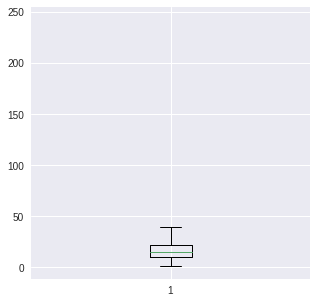

In [0]:
word_lengths = [len(t.split()) for t in df.short_description]
print(word_lengths)
fig,ax = plt.subplots(figsize=(5,5))
plt.boxplot(word_lengths)
plt.show()

Plot no of samples in each class

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


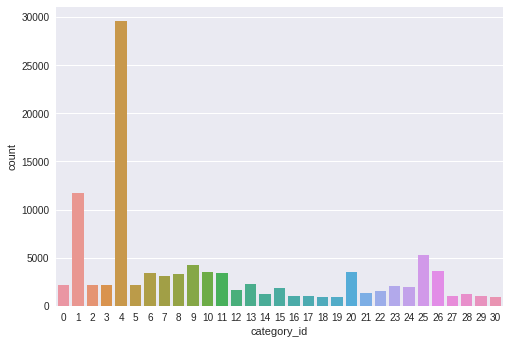

In [0]:
sns.countplot(df['category_id'])


In [0]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(df.index))
    plt.bar(index, word_lengths)
    plt.xlabel('no_words', fontsize=5)
    plt.ylabel('records', fontsize=5)
    #plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title('Market Share for Each Genre 1995-2017')
    plt.show()

In [0]:
plot_bar_x()

NameError: ignored

# **Analyzing Data**

Plotting wordcloud for different classes

In [0]:
from wordcloud import WordCloud
def plot_wordcloud(cat_id):
    categoryid = df[df.category_id == cat_id]
    catid = []
    for t in categoryid.short_description:
        catid.append(t)
    catid_text = pd.Series(catid).str.cat(sep=' ')   
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(catid_text)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

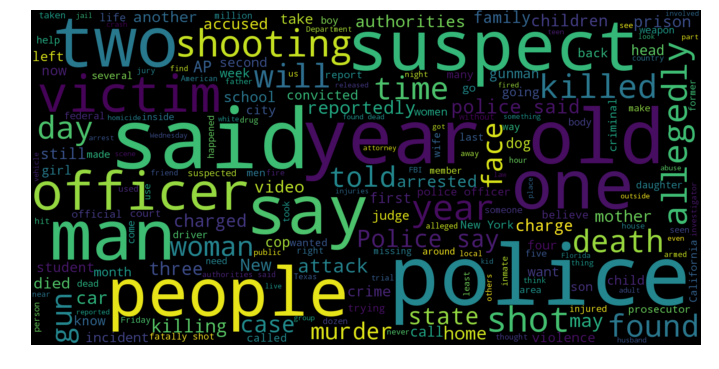

CRIME


In [0]:
plot_wordcloud(0) #class crime
print(mapDict[0])

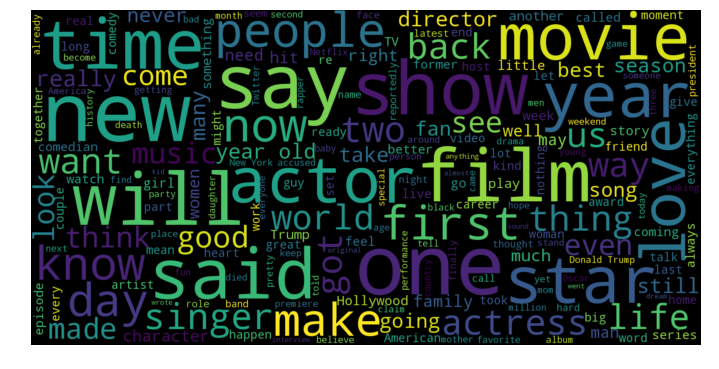

ENTERTAINMENT


In [0]:
plot_wordcloud(1) #class entertainment
print(mapDict[1])

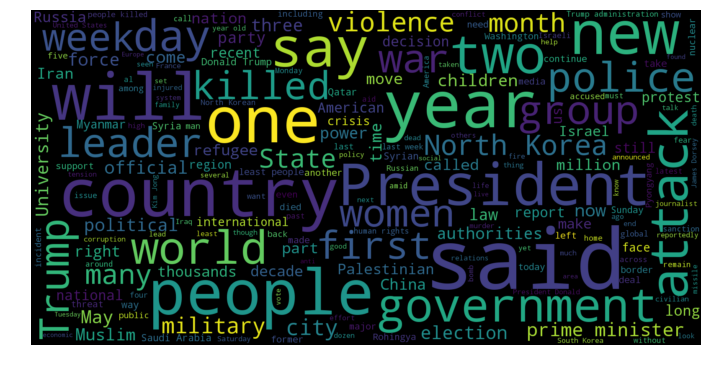

WORLD NEWS


In [0]:
plot_wordcloud(2) #class politics
print(mapDict[2])

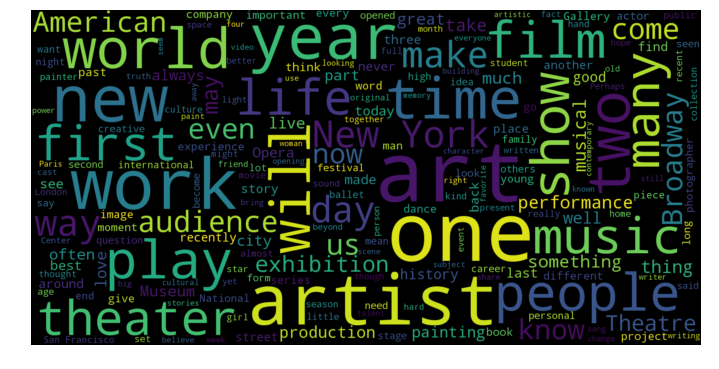

ARTS


In [0]:
plot_wordcloud(30)
print(mapDict[30])

**Term Frequencies for each news class using CountVectorizer**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cvector = CountVectorizer(stop_words='english',min_df = 0.0, max_df = 1.0, ngram_range=(1,2),max_features=10000)
cvector.fit(df.short_description)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=0.0,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [0]:
len(cvector.get_feature_names())

10000

In [0]:

def create_term_frequencies(cat_id):
    word_matrix = cvector.transform(df[df.category_id == cat_id].short_description)
    words = word_matrix.sum(axis=0)
    words_freq = [(word, words[0, idx]) for word, idx in cvector.vocabulary_.items()]
    
    name=mapDict[cat_id]
    
    
    tf = pd.DataFrame(list(sorted(words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms',name])
    tf_df = tf.set_index('Terms')
    return tf_df

In [0]:
from tqdm import tqdm
tfs=[]
for cat_id in tqdm(range(31)):
    tfs.append(create_term_frequencies(cat_id))


100%|██████████| 31/31 [00:03<00:00,  8.48it/s]


**Term frequencies for category_id 1**

In [0]:
tfs[1].head()

,ENTERTAINMENT
Terms,
new,580
just,457
like,438
said,373
film,359


**concatenating term frequencies for every class**

In [0]:
term_freq_df = pd.concat(tfs,axis=1) 

In [0]:
term_freq_df['total'] = 0
for i in range(0,31):
    name=''
    for maps in dedup:
        if maps[1]==i:
            name=maps[0]
    term_freq_df['total']+=tfs[i][name]

**Total Term Frequency of all the classes**

In [0]:
term_freq_df.sort_values(by='total', ascending=False).head(20)

,CRIME,ENTERTAINMENT,WORLD NEWS,IMPACT,POLITICS,WEIRD NEWS,BLACK VOICES,WOMEN,COMEDY,QUEER VOICES,...,STYLE,GREEN,TASTE,HEALTHY LIVING,THE WORLDPOST,GOOD NEWS,WORLDPOST,FIFTY,ARTS,total
people,126,251,146,292,1317,64,198,156,112,369,...,38,148,37,426,301,49,117,124,52,5396
trump,5,189,107,17,3973,22,55,56,170,73,...,6,55,2,21,112,0,2,7,0,5237
new,66,580,77,144,1276,49,161,128,79,253,...,67,127,53,300,109,20,109,91,122,5152
said,248,373,194,18,2004,83,251,88,52,183,...,9,51,8,59,270,22,19,39,16,4668
just,65,457,45,143,966,110,147,210,181,192,...,76,98,113,316,57,56,71,115,44,4624
time,41,322,27,142,837,46,115,186,94,169,...,68,98,98,405,53,44,82,159,55,4222
like,45,438,32,94,875,86,103,196,197,181,...,80,81,98,276,37,49,69,146,61,4195
president,6,88,120,13,2554,15,53,28,129,62,...,5,49,0,17,179,1,100,6,1,3753
year,164,343,66,147,666,49,137,92,45,149,...,43,80,46,172,139,31,65,83,48,3308
world,9,183,71,239,431,38,58,121,52,116,...,23,121,25,150,119,39,191,56,79,3011



**Frequency plot of top frequent 500 phrases in news **


Text(0.5,1,'Top 500 phrases in News Descriptions')

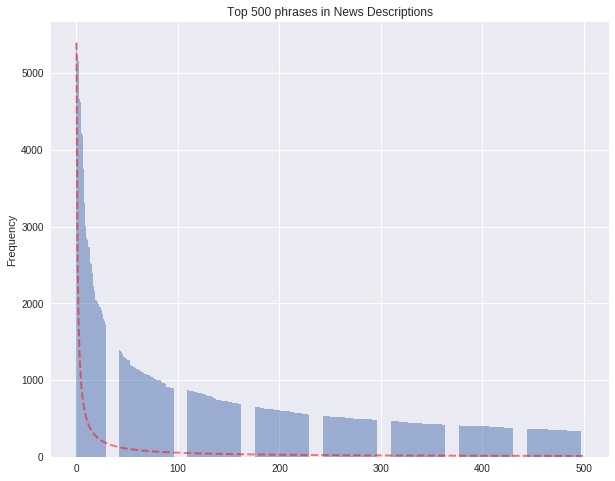

In [0]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 phrases in News Descriptions')


**
Plot of Absolute frequency of phrases against their rank
**

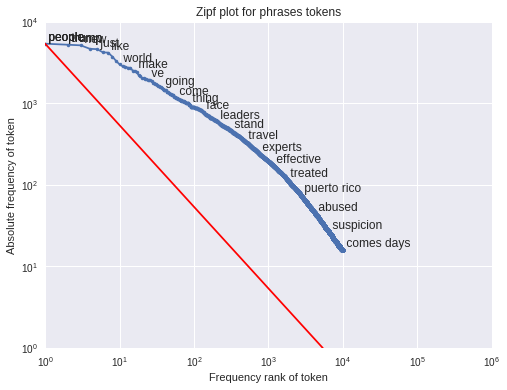

In [0]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**4)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for phrases tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")


**Plot of top frequently used 50 phrases in different news categories**

In [0]:
def top_tokens_from_cat(cat):
    y_pos = np.arange(50)
    plt.figure(figsize=(12,10))
    plt.bar(y_pos, term_freq_df.sort_values(by=cat, ascending=False)[cat][:50], align='center', alpha=0.5)
    plt.xticks(y_pos, term_freq_df.sort_values(by=cat, ascending=False)[cat][:50].index,rotation='vertical')
    plt.ylabel('Frequency')
    plt.xlabel('Top 50 '+str(cat)+' tokens')
    plt.title('Top 50 tokens in '+str(cat)+' news descriptions')
    


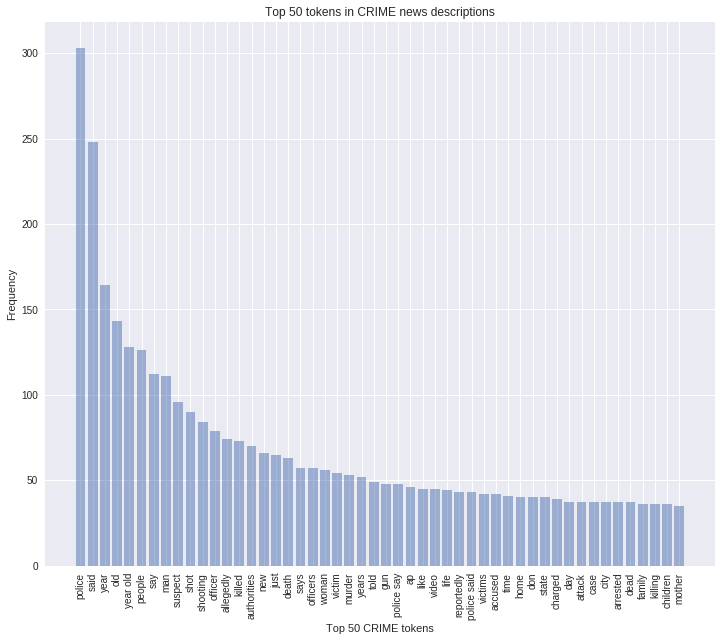

In [0]:
top_tokens_from_cat('CRIME')

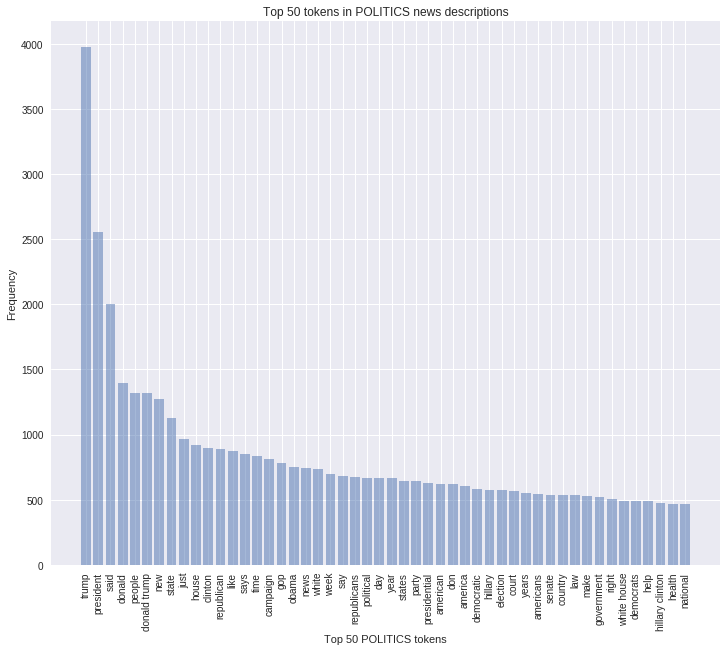

In [0]:
top_tokens_from_cat('POLITICS')

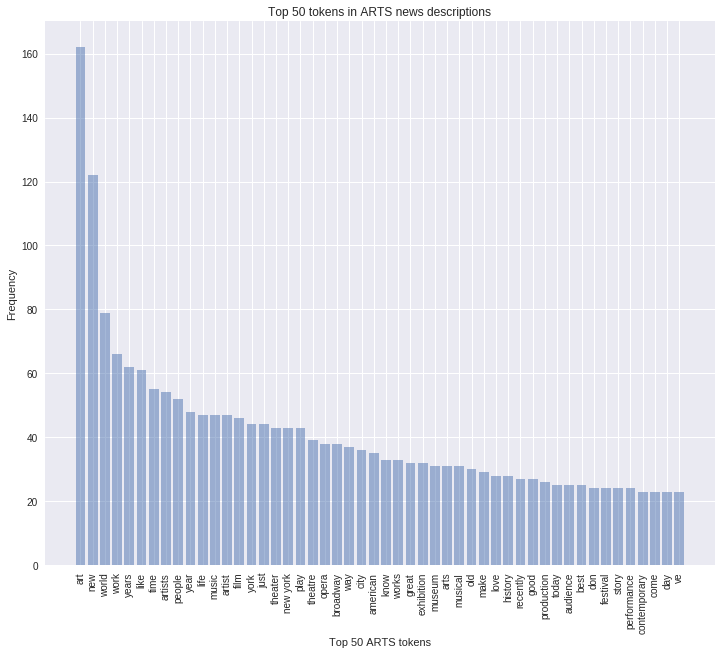

In [0]:
top_tokens_from_cat('ARTS')

# Building Models

In [0]:
descs = np.array(df['short_description'])
cats = np.array(df['category_id'])
# build train and test datasets

from sklearn.model_selection import train_test_split    
X_train, X_test, Y_train, Y_test = train_test_split(descs,cats, test_size=0.2, random_state=4)

**Using two kinds of features CountVectorizer features and Tf idf features**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Build Bag-Of-Words on train phrases
cv = CountVectorizer(stop_words='english',max_features=10000)
cv_train_features = cv.fit_transform(X_train)

**Plotting Datapoints as scatter plots**

In [0]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

def plot_datapoints(X,y):
    svd = TruncatedSVD(n_components=2)
    data2D = svd.fit_transform(X)
    colors = [{0:'#e6194b',1: '#3cb44b',2: '#ffe119',3: '#4363d8',4: '#f58231',5: '#911eb4',6: '#46f0f0',\
           7: '#f032e6',8: '#bcf60c',9: '#fabebe',10: '#008080',11: '#e6beff',12: '#9a6324',13: '#fffac8',\
           14: '#800000',15: '#aaffc3',16: '#808000',17: '#ffd8b1',18: '#000075',19: '#808080',\
           20: '#ffffff',21: '#000000',22:'#B0BF1A',23:'#7CB9E8',24:'#72A0C1',25:'#EDEAE0',26:'#F0F8FF',\
           27:'#C46210',28:'#EFDECD',29:'#FFBF00',30:'#9966CC'}[v] for v in y]

    plt.scatter(data2D[:, 0], data2D[:, 1], c=colors, linewidth=0.5, edgecolor='black')
    sns.despine()
    plt.title("Data Points")

**Scatter plot of count vectorizer features**

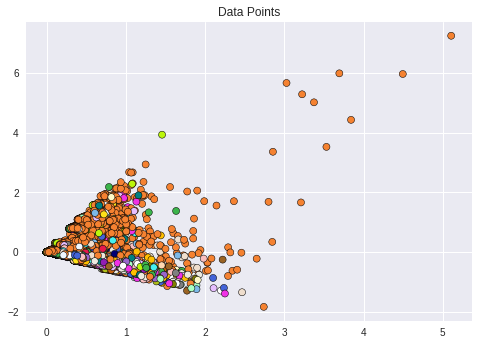

In [0]:
plot_datapoints(cv_train_features,Y_train)

**scatter plot of tfidf features**

In [0]:

tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True,max_features=10000)
tv_train_features = tv.fit_transform(X_train)

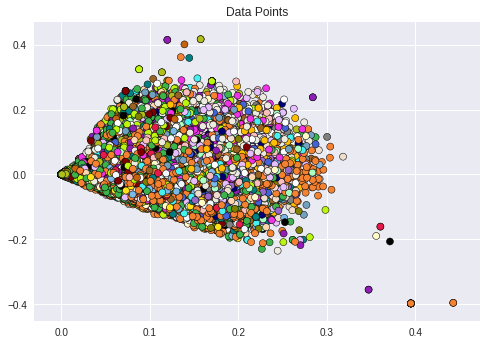

In [0]:
plot_datapoints(tv_train_features,Y_train)

In [0]:
# transform test descriptions into features
cv_test_features = cv.transform(X_test)
tv_test_features = tv.transform(X_test)

In [0]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)


BOW model:> Train features shape: (84319, 10000)  Test features shape: (21080, 10000)
TFIDF model:> Train features shape: (84319, 10000)  Test features shape: (21080, 10000)


**Functions for training a model and getting metrics**

In [0]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    



    

    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
   
    




**Getting linear models like LogisticRegression and SGD classifier for classification**

In [0]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
sgd = SGDClassifier(loss='hinge', n_iter=100)

In [0]:
lr_bow_predictions = train_predict_model(classifier=lr, 
                                             train_features=cv_train_features, train_labels=Y_train,
                                             test_features=cv_test_features, test_labels=Y_test)
display_model_performance_metrics(true_labels=Y_test, predicted_labels=lr_bow_predictions,
                                      classes=list(range(31)))
                                    

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.4425
Precision: 0.4246
Recall: 0.4425
F1 Score: 0.4041


**Plotting decision Boundary of the model by converting the data into two dimensions using TruncatedSVd**

In [0]:
def red_dimensions(X):
    svd = TruncatedSVD(n_components=2)
    data2D = svd.fit_transform(X)
    return data2D
def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    train_features=red_dimensions(train_features)
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()

**Decision surface for Logistic Regression**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


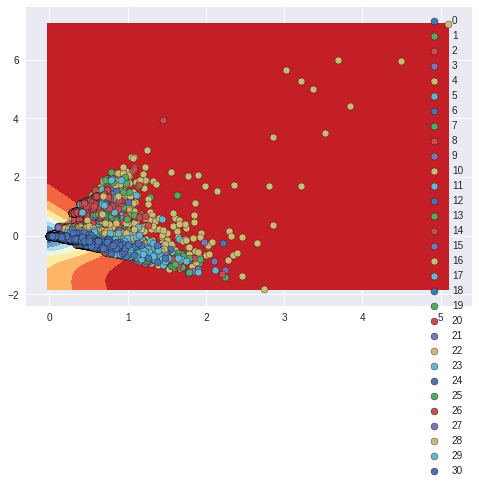

In [0]:

plot_model_decision_surface(lr,cv_train_features,Y_train)

**Logistic Regression model on TF-IDF features**

In [0]:
# Logistic Regression model on TF-IDF features
lr_tfidf_predictions = train_predict_model(classifier=lr, 
                                               train_features=tv_train_features, train_labels=Y_train,
                                               test_features=tv_test_features, test_labels=Y_test)
display_model_performance_metrics(true_labels=Y_test, predicted_labels=lr_tfidf_predictions,
                                      classes=list(range(31)))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.4359
Precision: 0.4546
Recall: 0.4359
F1 Score: 0.375


**Decision surface of Logistic Regression on tfidf features**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


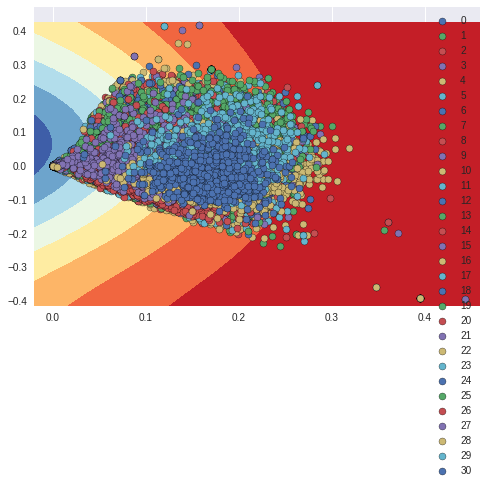

In [0]:
plot_model_decision_surface(lr,tv_train_features,Y_train)

**Training SGD using CountVectorizer features**

In [0]:
sgd_bow_predictions = train_predict_model(classifier=sgd, 
                                             train_features=cv_train_features, train_labels=Y_train,
                                             test_features=cv_test_features, test_labels=Y_test)
display_model_performance_metrics(true_labels=Y_test, predicted_labels=sgd_bow_predictions,
                                      classes=list(range(31)))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.4341
Precision: 0.4019
Recall: 0.4341
F1 Score: 0.4096


**Plotting decision surface of SGD on CountVectorizer features**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


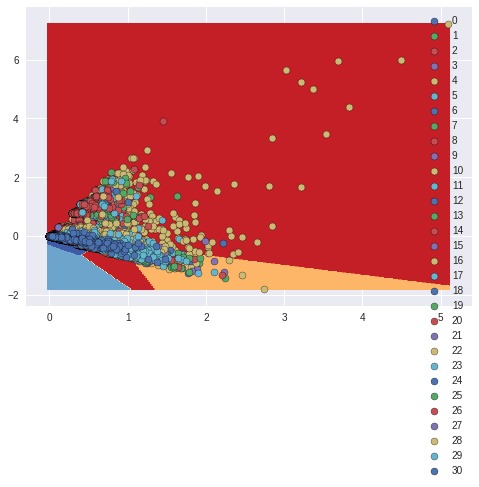

In [0]:
plot_model_decision_surface(sgd,cv_train_features,Y_train)

**Training SGD usingnTfIDF features**

In [0]:
sgd_bow_predictions = train_predict_model(classifier=sgd, 
                                             train_features=tv_train_features, train_labels=Y_train,
                                             test_features=tv_test_features, test_labels=Y_test)
display_model_performance_metrics(true_labels=Y_test, predicted_labels=sgd_bow_predictions,
                                      classes=list(range(31)))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.4168
Precision: 0.3714
Recall: 0.4168
F1 Score: 0.3766


**Plotting decision surface of SGD on TFIDF features**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


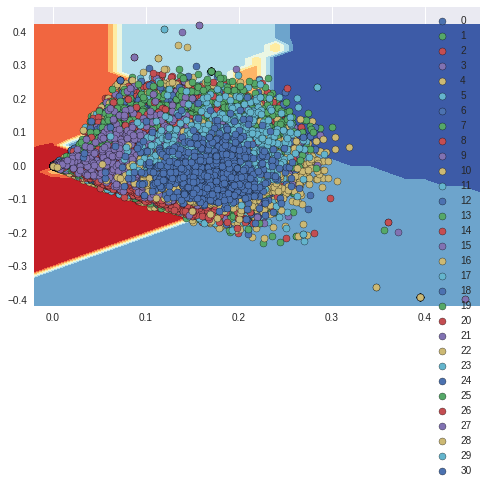

In [0]:
plot_model_decision_surface(sgd,tv_train_features,Y_train)

In [0]:
from sklearn import svm
clf = svm.SVC(gamma='scale')


In [0]:
# RandomForest model on TF-IDF
clf_tfidf_predictions = train_predict_model(classifier=clf, 
                                                train_features=cv_train_features, train_labels=Y_train,
                                                test_features=cv_test_features, test_labels=Y_test)
display_model_performance_metrics(true_labels=Y_test, predicted_labels=clf_tfidf_predictions,
                                      classes=list(range(31)))

In [0]:
plot_model_decision_surface(clf,cv_train_features,Y_train)

NameError: ignored

**Training  a fully connected neural network using CountVectorizer features**

In [0]:
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers


In [0]:
model = models.Sequential()
# Input - Layer
model.add(layers.Dense(50, activation = "relu", input_shape=(10000, )))
# Hidden - Layers
model.add(layers.Dropout(0.5, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.5, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(layers.Dense(31, activation = "softmax"))
model.summary()
# compiling the model
model.compile(
 optimizer = "adam",
 loss = "sparse_categorical_crossentropy",
 metrics = ["accuracy","categorical_accuracy"]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                500050    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 31)                1581      
Total params: 506,731
Trainable params: 506,731
Non-trainable params: 0
_________________________________________________________________


In [0]:
results = model.fit(
 cv_train_features, Y_train,
 epochs= 10,
 batch_size = 500,
 validation_data = (cv_test_features, Y_test)
)


Train on 84319 samples, validate on 21080 samples
Epoch 1/10
84319/84319 [==============================] - 7s 81us/step - loss: 2.8942 - acc: 0.2747 - categorical_accuracy: 0.0026 - val_loss: 2.6100 - val_acc: 0.3237 - val_categorical_accuracy: 0.0000e+00
Epoch 2/10
84319/84319 [==============================] - 6s 75us/step - loss: 2.5076 - acc: 0.3428 - categorical_accuracy: 0.0000e+00 - val_loss: 2.3860 - val_acc: 0.3636 - val_categorical_accuracy: 0.0000e+00
Epoch 3/10
84319/84319 [==============================] - 6s 74us/step - loss: 2.3416 - acc: 0.3709 - categorical_accuracy: 0.0000e+00 - val_loss: 2.3272 - val_acc: 0.3773 - val_categorical_accuracy: 0.0000e+00
Epoch 4/10
84319/84319 [==============================] - 6s 74us/step - loss: 2.2474 - acc: 0.3901 - categorical_accuracy: 3.2021e-04 - val_loss: 2.2921 - val_acc: 0.3875 - val_categorical_accuracy: 1.4231e-04
Epoch 5/10
84319/84319 [==============================] - 6s 75us/step - loss: 2.1695 - acc: 0.4034 - categori

**Plotting accuracy graphs**

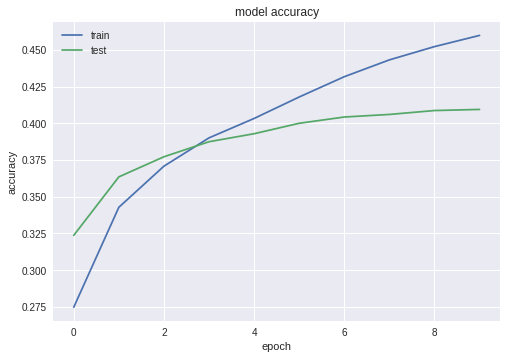

In [0]:
def plot_acc_curve():
  plt.plot(results.history['acc'])
  plt.plot(results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
plot_acc_curve()  
  

**Plotting loss curves**

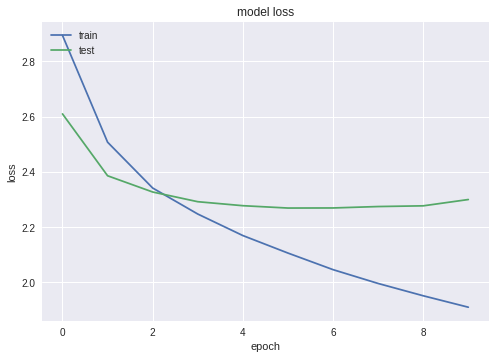

In [0]:
def plot_loss_curve():
  plt.plot(results.history['loss'])
  plt.plot(results.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
plot_loss_curve()  
  

*Analysis Drawn from data*

1. The data contains imbalanced classes so Oversampling or Under sampling the data might be useful
2. Some classes like World News , Politics and quite indistinguishable from each other so most models find it difficult to separate the two.
3. The above discrepancy might be overcome by obtaining more data in these classes.


*Model observations*


The best model trained was the Logistic Regression model which gave an accuracy of 44 percent (against random pred. accuracy of 3 percent) and an f1 score of 0.38.



*Future Work*

1. Oversampling the data to make the classes more balanced
2. Use LSTMs and RNNs for predictions with pre-trained glove embeddings



*Computing Resources Used*

This notebook was compiled using google colab in the GPU runtime .